* In addition to compare mean current of model results with codar by the same method, how about the idealized caseof mean current? That is, to run only with rivers, no tides, no weather. Two speculations of the potential results:

* 1 Only river mean flow is closer to codar, that indicates winds effects much of the mean currents in the previous way.
* 2 None of them is closer to codar, something else is still going on...
* 3 Analyze difference between only river and all conditions.

In [1]:
%matplotlib inline
from IPython.core.display import Image,display
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
import datetime
from salishsea_tools import (viz_tools,tidetools,nc_tools,stormtools)
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import os
import glob
import codar
stations = {'Westshore': {'lat': 49.018,'lon': -123.1719},
            'Iona':{'lat': 49.2159, 'lon': -123.2054}}
bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)

In [2]:
## load data
codar_data = sio.loadmat('/ocean/jieliu/research/meopar/surface current/SoG_radar_totals.mat')
t = codar_data['mtime']
lat_codar = codar_data['glat']
lon_codar = codar_data['glon']
u = codar_data['u']
v = codar_data['v']
## load radial data
iona_data = sio.loadmat('/ocean/jieliu/research/meopar/surface current/ionaRadialGrid.mat')
west_data = sio.loadmat('/ocean/jieliu/research/meopar/surface current/westRadialGrid')

In [3]:
## load different bathys
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X={};Y={};bathy={};grids = [grid2,grid6]
for grid in grids:
    X[grid] = grid.variables['nav_lon'][:, :]
    Y[grid] = grid.variables['nav_lat'][:, :]
    bathy[grid] = grid.variables['Bathymetry'][:, :]
## load grid6 model result
uv_all = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/OctMeanCurrent/codar_all_large.nc'); 
## load grid6 only river model result
uv_onlyRiver = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/OnlyRiver/codar_onlyriver.nc'); 

* Select time

In [4]:
run_low = datetime.datetime(2015,10,1,0);
run_up = datetime.datetime(2015,11,1,0);

In [5]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st = 3

In [6]:
def load_model(uv_all,u_new, v_new,u_m,v_m,U_m,V_m,lon,lat,string,select_flag = True):
    """This function is to load grid6 model result,
     no matter for only river or all conditions"""
    u_6 = uv_all.variables['vozocrtx']
    v_6 = uv_all.variables['vomecrty']
    u_mean6 = np.nanmean(u_6, axis = 0)
    v_mean6 = np.nanmean(v_6, axis = 0)

    u_m[string] =u_mean6[0,:,:]
    v_m[string] =v_mean6[0,:,:]
    ##unstagger u v
    U_m[string],V_m[string] = viz_tools.unstagger(u_m[string],v_m[string])
    #rotate
    theta = np.pi*29/180
    U_m[string] = U_m[string]*np.cos(theta) - V_m[string]*np.sin(theta)
    V_m[string] = U_m[string]*np.sin(theta) +V_m[string]*np.cos(theta)
    ##mask
    U_m[string]=np.ma.masked_values(U_m[string],0)
    V_m[string]=np.ma.masked_values(V_m[string],0)

    ## select codar domain or not
    if select_flag ==True:
        U_m['new'], V_m['new'] = mask_ModelResult(u_new,v_new,X[grid6],Y[grid6],bathy[grid6],\
                                U_m,V_m, string,flag = 'grid6')
        lon[grid6] = X[grid6][380:479,240:319]
        lat[grid6] = Y[grid6][380:479,240:319]
    else:
        U_m['new'] = U_m[string]; V_m['new'] = V_m[string];
        lon[grid6] = X[grid6]
        lat[grid6] = Y[grid6]
    return lon, lat, U_m['new'], V_m['new']

In [7]:
def mask_ModelResult(u_new,v_new,X,Y,bathy,U_m,V_m,string,flag = 'grid2'):
    """This function is to mask the model result outside codar domain """
    i_ind = [] ## mask indices to apply for a model result
    j_ind= []
    mm = ma.masked_invalid(np.sqrt(u_new**2+v_new**2))
    
    #U_m_new = np.copy(U_m) ## set up new U_m and V_m array for applying the mask
    #U_m_new = ma.array(U_m_new, mask =True)
    #V_m_new = np.copy(V_m)
    #V_m_new = ma.array(V_m_new, mask =True)
    U_m['new'] = U_m[string]
    U_m['new'] = ma.array(U_m['new'], mask =True)
    V_m['new'] = V_m[string]
    V_m['new'] = ma.array(V_m['new'], mask =True)
    
    for j in range(46):
        for i in range(36):
            if mm[j,i] != 1e+20:
                [jj,ii] = tidetools.find_closest_model_point(lon_codar[j,i],lat_codar[j,i],\
                            X,Y,bathy,lat_tol=0.0021)
                if flag == 'grid2':
                    j_ind.append(jj)
                    i_ind.append(ii)
                elif flag =='grid6':
                    jj = jj - 380 ## start j of the subdomain in grid6
                    ii = ii - 240## start i of the subdomain in grid6
                    j_ind.append(jj)
                    i_ind.append(ii)
    j_inds = np.array(j_ind)
    i_inds = np.array(i_ind)

    if flag == 'grid2':
        for j in np.arange(481,380,-1):
            for i in np.arange(240,330,1):
                for k in range (len(j_inds)):
                    if (j == j_inds[k]) and (i== i_inds[k]):         
                        U_m['new'][j,i] = U_m[string][j,i]
                        V_m['new'][j,i] = V_m[string][j,i]
    elif flag =='grid6':
        for j in np.arange(99,-1,-1):
            for i in np.arange(0,80,1):
                for k in range (len(j_inds)):
                    if (j == j_inds[k]) and (i== i_inds[k]):         
                        U_m['new'][j,i] = U_m[string][j,i]
                        V_m['new'][j,i] = V_m[string][j,i]
    return U_m['new'], V_m['new']

In [8]:
def plot_both(run_low,run_up,cmin=0,cmax = 0.1):
    fig = plt.figure(figsize=(42,12))
    gs = gridspec.GridSpec(1, 3,width_ratios=[1, 1,1])  
    gs.update(hspace=0.15, wspace=0.1)
    ##plot codar quiver
    ax0 = fig.add_subplot(gs[0,0])
    ax0.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='SpringGreen')
    
    p_low, ind_low = codar.python_time(run_low,t); p_up, ind_up = codar.python_time(run_up,t)
    sta = np.zeros((46,36));
    for j in range(46):
        for i in range(36): ## count of nan
            sta[j,i] = 100*np.sum(np.isnan(u[j,i,ind_low:ind_up]))/(ind_up-ind_low)
    sta[sta<50] = 0 ##selet good data
    sta[sta>=50] = 1
    uu = np.ma.masked_array(u[:,:,0], sta)
    mask = uu.mask ## mask array
    ## mask is equal to mask array, broadcast here!
    mask_expand = np.expand_dims(mask, axis=2)
    mask_expand = mask_expand + np.zeros(u.shape) #broadcasting here!
    #Apply mask
    u_mask = np.ma.masked_array(u,mask=mask_expand)
    v_mask = np.ma.masked_array(v,mask=mask_expand)
    
    u_new = np.nanmean(u_mask[:,:,ind_low:ind_up]/100,axis = 2); ##average the whole time period in a month
    v_new = np.nanmean(v_mask[:,:,ind_low:ind_up]/100,axis = 2)
    ## plot codar
    ax0.plot(iona_data['gridLon'],iona_data['gridLat'],'b--')
    ax0.plot(west_data['gridLon'],west_data['gridLat'],'g--')
    mesh=ax0.pcolormesh(lon_codar,lat_codar, ma.masked_invalid(np.sqrt(u_new**2+v_new**2)), cmap='Reds', \
                        vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax0)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = ax0.quiver(lon_codar, lat_codar,u_new,v_new, pivot='mid', scale = 2,width=0.005, color='black')
    ax0.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s',coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    ## plot stns
    names = ['Iona', 'Westshore']
    for stn in names:
        ax0.annotate(stn, (stations[stn]['lon']+0.02, stations[stn]['lat']), color='black', bbox=bbox_args,fontsize = 15)
    print ('mean flow of codar is '+str(np.nanmean(np.sqrt(u_new**2+v_new**2)))+' m/s')
    ## plot modelled surface currents (bathy2)
    ax1 = fig.add_subplot(gs[0,1]); ax2 = fig.add_subplot(gs[0,2])
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={} 
    ## grid6 all condition model result
    lon, lat, U_m['new1'], V_m['new1'] = load_model(uv_all,u_new,v_new,u_m,v_m,U_m,V_m,lon,lat,'uv')  
    ## grid6 only river model result
    lon, lat, U_m['new2'], V_m['new2'] = load_model(uv_onlyRiver,u_new,v_new,u_m,v_m,U_m,V_m,lon,lat,'uv_onlyRiver')
    ## plot
    inds = ['new1','new2']
    for ax,ind in zip([ax1,ax2],inds):
        mesh=ax.pcolormesh(lon[grid6], lat[grid6], \
            np.sqrt(U_m[ind]**2+V_m[ind]**2), cmap='Reds', vmin=cmin, vmax=cmax)
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Total Velocity[m/s]', fontsize = 20)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
        quiver = ax.quiver(lon[grid6], lat[grid6],U_m[ind], V_m[ind],\
                        pivot='mid',scale=2,width=0.005, color='black' ) 
        ax.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                fontproperties = {'size': '15'})
    titles = ['data','uv_all','uv_onlyriver']
    for ax, title in zip([ax0,ax1,ax2],titles):
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
        ax.set_xlim([-123.7,-123])
        ax.set_ylim([48.95,49.3])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
        ax.set_title(title,fontsize = 20)

    return fig

mean flow of codar is 0.0796759634364 m/s


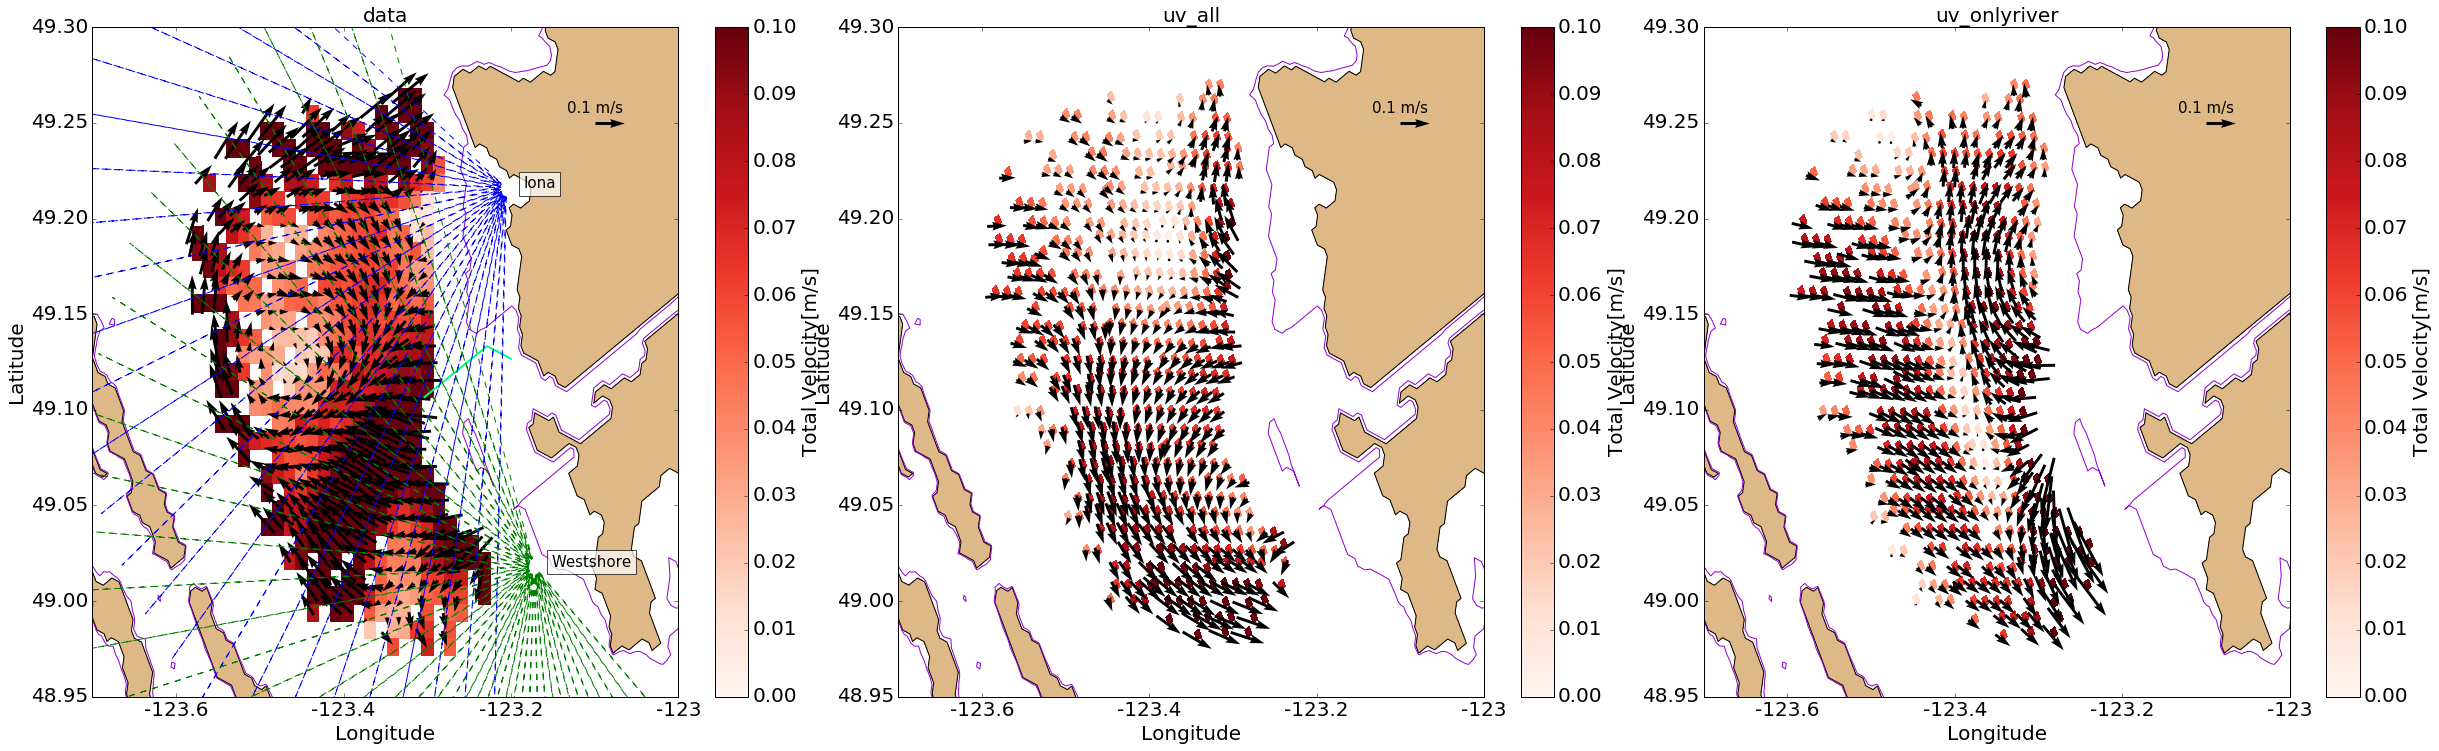

In [9]:
fig = plot_both(run_low,run_up)

In [10]:
def plot_only_model(uv_all,uv_onlyRiver,strings,cmin = 0, cmax = 0.3):
    """This function is made to only plot different model results of mean currents"""
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={};
    fig, axs = plt.subplots(1,3,figsize = (21,6))
    titles = ['uv_all','uv_onlyriver','uv_onlyriver-uv_all']
    for file, string,ax in zip([uv_all,uv_onlyRiver],strings, [axs[0],axs[1]]):
        u_6 = file.variables['vozocrtx']
        v_6 = file.variables['vomecrty']
        u_mean6 = np.nanmean(u_6, axis = 0)
        v_mean6 = np.nanmean(v_6, axis = 0)

        u_m[string] =u_mean6[0,:,:]
        v_m[string] =v_mean6[0,:,:]
        ##unstagger u v
        U_m[string],V_m[string] = viz_tools.unstagger(u_m[string],v_m[string])
        #rotate
        theta = np.pi*29/180
        U_m[string] = U_m[string]*np.cos(theta) - V_m[string]*np.sin(theta)
        V_m[string] = U_m[string]*np.sin(theta) +V_m[string]*np.cos(theta)
        ##mask
        U_m[string]=np.ma.masked_values(U_m[string],0)
        V_m[string]=np.ma.masked_values(V_m[string],0)
        lon[string] = X[grid6][380:479,240:319]
        lat[string] = Y[grid6][380:479,240:319]
        ## plot
        mesh=ax.pcolormesh(lon[string], lat[string], \
            np.sqrt(U_m[string]**2+V_m[string]**2), cmap='Reds', vmin=cmin, vmax=cmax)
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Total Velocity[m/s]', fontsize = 20)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
        quiver = ax.quiver(lon[string][::st,::st], lat[string][::st,::st],\
                           U_m[string][::st,::st], V_m[string][::st,::st],\
                        pivot='mid',scale=2.5,width=0.005, color='black' ) 
        ax.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                fontproperties = {'size': '15'})
    ##diff plot
    mesh=axs[2].pcolormesh(lon[strings[1]], lat[strings[1]], \
            np.sqrt(U_m[strings[1]]**2+V_m[strings[1]]**2)-np.sqrt(U_m[strings[0]]**2+V_m[strings[0]]**2),\
                    cmap='bwr', vmin=-0.1, vmax=0.1)
    cbar = plt.colorbar(mesh, ax=axs[2])
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = axs[2].quiver(lon[strings[1]][::st,::st], lat[strings[1]][::st,::st],\
                       U_m[strings[1]][::st,::st]-U_m[strings[0]][::st,::st],\
                       V_m[strings[1]][::st,::st]-V_m[strings[0]][::st,::st],\
                        pivot='mid',scale=2.5,width=0.005, color='black' ) 
    axs[2].quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                fontproperties = {'size': '15'})
    for ax,title in zip(axs,titles):
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
        ax.set_xlim([-123.7,-123])
        ax.set_ylim([48.95,49.3])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
        ax.set_title(title,fontsize = 20)
    return fig     

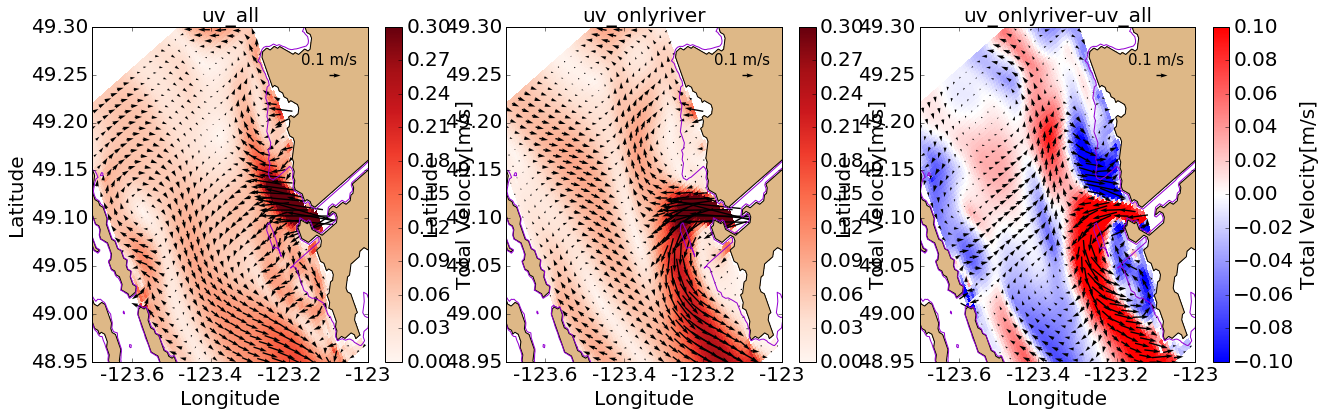

In [11]:
fig = plot_only_model(uv_all,uv_onlyRiver,['uv_all','uv_onlyRiver'])

* Not essential change between modelled case, that is, southward flow is still dominant. 
* Only river case is very physical, with a large part of surface currents going southward, which accounts for a portion of estuary circulation in the Strait, the other part of the currents going north, that can be due to the  Coriolis force.
* Tides and winds are important in changing the mean flow pattern. After checking with Mark, several conclusions can be derived:
1) His hypothesis of the mean current is mostly dominated by river flow might be too simple in the real world case, or the model can be wrong.
2) The mechanism that cause the southward outflow can be the pressure gradient, or the tidal residuals.
3) A feed to do the tidal harmonics to acquire tidal residuals and take a look at its direction?? But it is too complicated to do that as you need to get rid of each tidal component. Will estimate the portion of tidal residuals by using Susan's method.

# Check stratification

* My original idea is that under condition without tides and winds, averaging the same time period, I should got what Mark shows the mean current in his paper. However, Nancy pointed out that without tides, not only within the plume region the circulation diminished, but also the whole estuarine circulation in the Salish Sea terminated, which might not be realistic to do so. Thus, I need to check the stratification by the end of run and decide where to go!

In [12]:
grid_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/OnlyRiver/codar_onlyriver_T.nc')

In [13]:
S = grid_T.variables['vosaline']

In [ ]:
def plot_vertical_S(ind_dep,types,cmin = 0,cmax = 28):
    fig, axs = plt.subplots(1,2,figsize = (14,4))
    cmap  = plt.get_cmap('jet')
    ncs = [uv,uv_hv]
    dep = uv.variables['depthu']
    #types = ['mean {u} velocity of lower viscosity case'.format(u=string),\
             #'mean {u} velocity of higher viscosity case'.format(u=string)]
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={};UU_m={}
    for nc,tp, ax in zip(ncs,types,axs):
        u_6= nc.variables['vozocrtx']
        v_6 = nc.variables['vomecrty']
        u_mean6 = np.nanmean(u_6, axis = 0)
        v_mean6 = np.nanmean(v_6, axis = 0)
        ##unstagger u v
        U_m[tp],V_m[tp] = viz_tools.unstagger(u_mean6,v_mean6)
        #rotate
        theta = np.pi*29/180
        U_m[tp] = U_m[tp]*np.cos(theta) - V_m[tp]*np.sin(theta)
        V_m[tp] = U_m[tp]*np.sin(theta) +V_m[tp]*np.cos(theta)
        ##mask
        U_m[tp]=np.ma.masked_values(U_m[tp],0)
        V_m[tp]=np.ma.masked_values(V_m[tp],0)
        lon = X[grid6][380:479,240:319]
        lat= Y[grid6][380:479,240:319]
        if string =='u':
            mesh = ax.contourf(lon[ind_dep,:],dep[:],
            U_m[tp][:,ind_dep,:], np.arange(cmin, cmax, 0.03),cmap=cmap)
        elif string =='v':
            mesh = ax.contourf(lon[ind_dep,:],dep[:],
            V_m[tp][:,ind_dep,:], np.arange(cmin, cmax, 0.03),cmap=cmap)
        elif string =='total':
            mesh = ax.contourf(lon[ind_dep,:],dep[:],
            np.sqrt(U_m[tp][:,ind_dep,:]**2+V_m[tp][:,ind_dep,:]**2), np.arange(0, 0.3, 0.03),cmap=cmap)
        plt.setp(ax.get_xticklabels(), fontsize=15)
        plt.setp(ax.get_yticklabels(), fontsize=15)
        cbar = fig.colorbar(mesh, ax=ax)
        cbar.set_label('[m/s]', fontsize = 15)
        ax.set_title(tp, fontsize = 15)
        ax.set_xlim([lon[ind_dep,0], lon[ind_dep,-1]])
        ax.set_ylim([dep[-8], 0])
        ax.set_ylabel('Depth [m]', fontsize = 15)
    return fig

